In [1]:
import pandas as pd
import numpy as np

In [2]:
# Load data
train_df = pd.read_csv("/pscratch/sd/r/ritesh11/temp_dir/dataset/train.csv")
test_df = pd.read_csv("/pscratch/sd/r/ritesh11/temp_dir/dataset/test.csv")
base_dir = "/pscratch/sd/r/ritesh11/temp_dir/dataset/kfold"

# Separate features and targets
feature_cols = train_df.columns[:55]
target_cols = train_df.columns[55:]

X = train_df[feature_cols].copy()
y = train_df[target_cols].copy()

In [3]:
X

,Component1_fraction,Component2_fraction,Component3_fraction,Component4_fraction,Component5_fraction,Component1_Property1,Component2_Property1,Component3_Property1,Component4_Property1,Component5_Property1,...,Component1_Property9,Component2_Property9,Component3_Property9,Component4_Property9,Component5_Property9,Component1_Property10,Component2_Property10,Component3_Property10,Component4_Property10,Component5_Property10
0,0.21,0.00,0.42,0.25,0.12,-0.021782,1.981251,0.020036,0.140315,1.032029,...,0.480368,1.044967,-0.450956,0.674572,-0.636394,-1.244963,-1.355050,-0.314423,0.993593,-2.728928
1,0.02,0.33,0.19,0.46,0.00,-0.224339,1.148036,-1.107840,0.149533,-0.354000,...,-1.958826,-0.019603,-0.807923,0.148715,1.439313,-1.160435,-0.014276,-0.135968,-1.221155,0.896222
2,0.08,0.08,0.18,0.50,0.16,0.457763,0.242591,-0.922492,0.908213,0.972003,...,-0.798978,-0.444027,0.148405,-0.793607,0.123834,0.006829,0.668734,0.015449,-0.098661,-0.424314
3,0.25,0.42,0.00,0.07,0.26,-0.577734,-0.930826,0.815284,0.447514,0.455717,...,-0.534135,1.155513,-0.760428,0.450159,-0.973779,0.052972,-1.024785,0.118951,2.400556,-0.576430
4,0.26,0.16,0.08,0.50,0.00,0.120415,0.666268,-0.626934,2.725357,0.392259,...,-0.389350,1.799238,-0.912374,1.767557,-0.467038,2.104922,0.858593,-0.469110,0.715789,-2.038341
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,0.50,0.12,0.00,0.26,0.12,0.279523,-0.054170,-0.391227,0.400222,1.032029,...,1.138839,1.666804,-1.413339,0.405253,0.766653,-0.322096,1.399468,1.096369,-0.346225,0.641193
1996,0.19,0.31,0.00,0.37,0.13,-0.887185,0.610050,0.178606,1.083154,-2.822749,...,-0.782418,0.784366,1.113626,1.328112,-2.537512,0.461525,0.647984,-0.618766,-0.047918,0.397253
1997,0.38,0.06,0.14,0.31,0.11,0.568978,-0.196759,-0.646318,-0.980070,1.032029,...,-0.813747,-0.197880,-0.549162,0.810814,1.567580,-0.694918,-1.710215,-0.233936,-0.133002,-0.284672
1998,0.50,0.16,0.00,0.18,0.16,-0.067453,0.321977,-0.137535,0.238507,0.017455,...,1.262477,-0.925444,-0.823345,0.427648,-0.161447,0.628131,-0.038484,0.343058,0.448748,0.193507


In [ ]:
import os
import pandas as pd
from sklearn.model_selection import KFold

def create_and_save_kfolds(X, y, n_splits=5, base_dir=".", random_state=42):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for target_col in y.columns:
        suffix = target_col.replace(" ", "_")

        for fold, (train_idx, val_idx) in enumerate(kf.split(X)):
            fold_dir = os.path.join(base_dir, f"Fold{fold}")
            train_dir = os.path.join(fold_dir, "train")
            val_dir = os.path.join(fold_dir, "val")
            os.makedirs(train_dir, exist_ok=True)
            os.makedirs(val_dir, exist_ok=True)

            # Split the data
            X_train_fold = X.iloc[train_idx]
            y_train_fold = y[[target_col]].iloc[train_idx]

            X_val_fold = X.iloc[val_idx]
            y_val_fold = y[[target_col]].iloc[val_idx]

            # Save each fold
            X_train_fold.to_csv(os.path.join(train_dir, f"{suffix}_X.csv"), index=False)
            y_train_fold.to_csv(os.path.join(train_dir, f"{suffix}_y.csv"), index=False, header=[target_col])

            X_val_fold.to_csv(os.path.join(val_dir, f"{suffix}_X.csv"), index=False)
            y_val_fold.to_csv(os.path.join(val_dir, f"{suffix}_y.csv"), index=False, header=[target_col])

        print(f"Saved 5-Fold splits for target: {target_col}")

In [15]:
from sklearn.cluster import KMeans
from sklearn.model_selection import StratifiedShuffleSplit

def create_per_target_val_sets(X, y, val_size=300, n_clusters=15, random_state=42):
    """
    For each target column in y, create a validation set that matches its distribution using KMeans.
    """
    val_sets = {}
    for col in y.columns:
        # Cluster this target column
        kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
        clusters = kmeans.fit_predict(y[[col]])
        
        # Stratified sampling on clusters
        sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
        train_idx, val_idx = next(sss.split(X, clusters))
        
        val_sets[col] = {
            'train_idx': train_idx,
            'val_idx': val_idx,
            'X_train': X.iloc[train_idx],
            'y_train': y[[col]].iloc[train_idx],
            'X_val': X.iloc[val_idx],
            'y_val': y[[col]].iloc[val_idx],
        }
    
    return val_sets

In [16]:
val_sets = create_per_target_val_sets(X, y)

for target_col, data in val_sets.items():
    X_train = data['X_train']
    y_train = data['y_train']
    X_val = data['X_val']
    y_val = data['y_val']

In [7]:
def plot_val_distributions(y_full, base_dir, split='val'):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import os

    for fold in range(5):
        data_dir = os.path.join(base_dir, f"Fold{fold}/{split}")
        
        for col in y_full.columns:
            val_y_path = os.path.join(data_dir, f"{col}_y.csv")
            
            if not os.path.exists(val_y_path):
                print(f"Skipping missing: {val_y_path}")
                continue

            val_y = pd.read_csv(val_y_path).squeeze()

            plt.figure(figsize=(8, 4))
            sns.kdeplot(y_full[col], label='Full Train', fill=True)
            sns.kdeplot(val_y, label=f'Fold{fold} {split}', linestyle='--', fill=True, alpha=0.5)
            plt.title(f"Distribution Match – {col} (Fold {fold})")
            plt.xlabel(col)
            plt.legend()
            plt.tight_layout()
            plt.show()

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


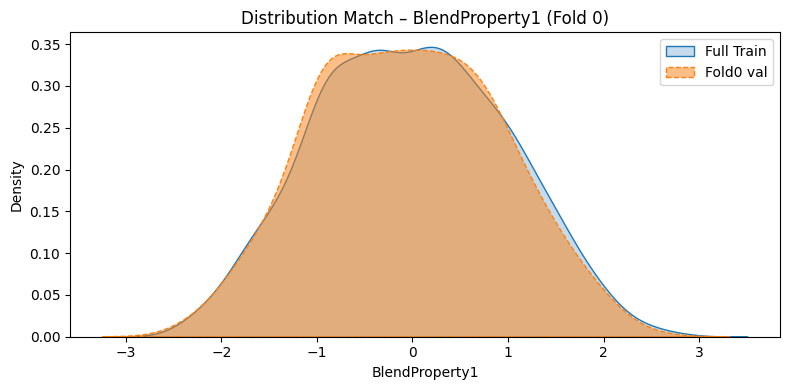

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


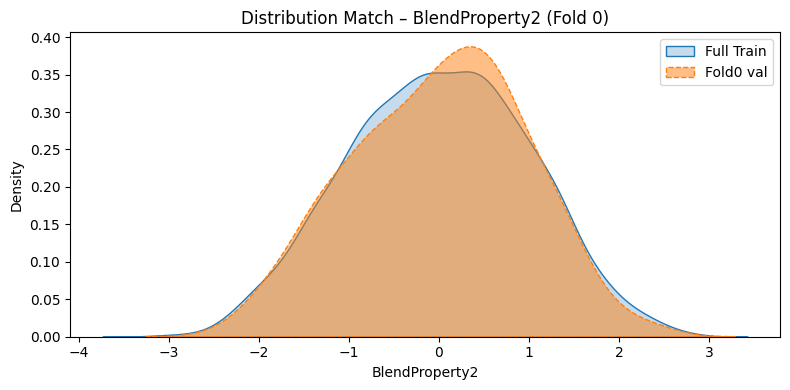

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


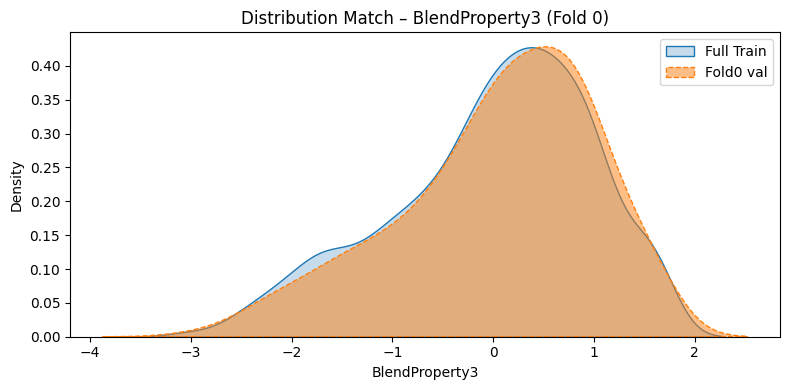

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


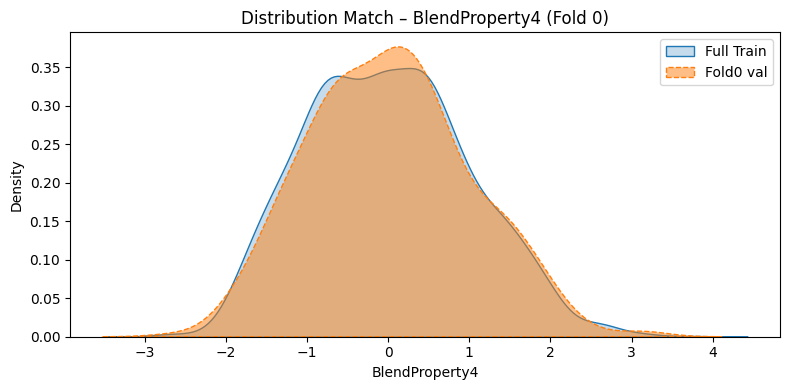

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


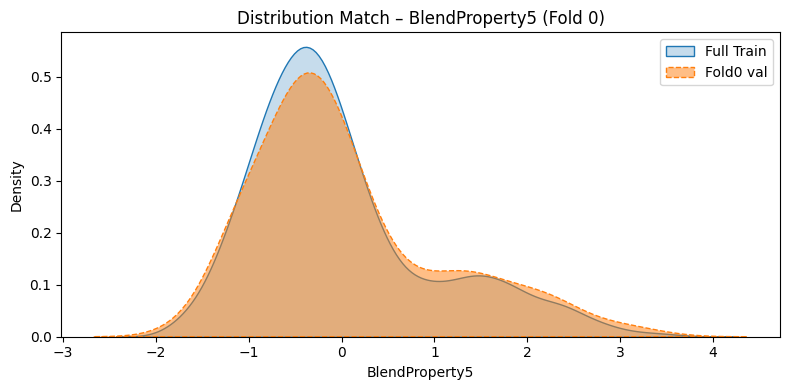

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


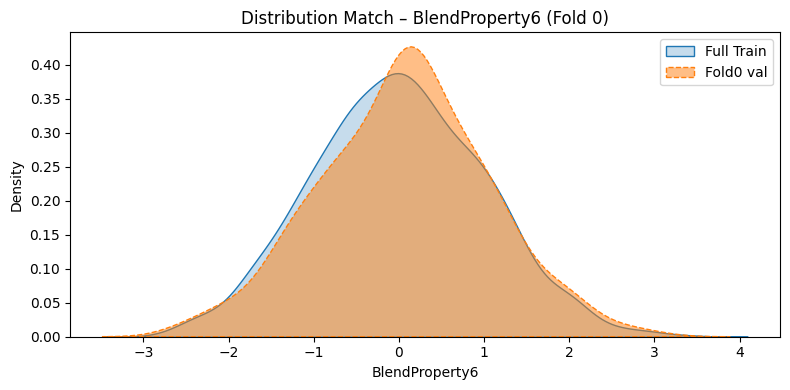

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


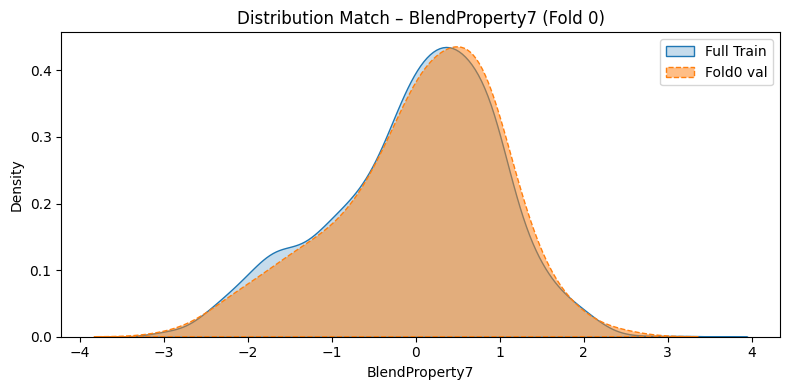

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


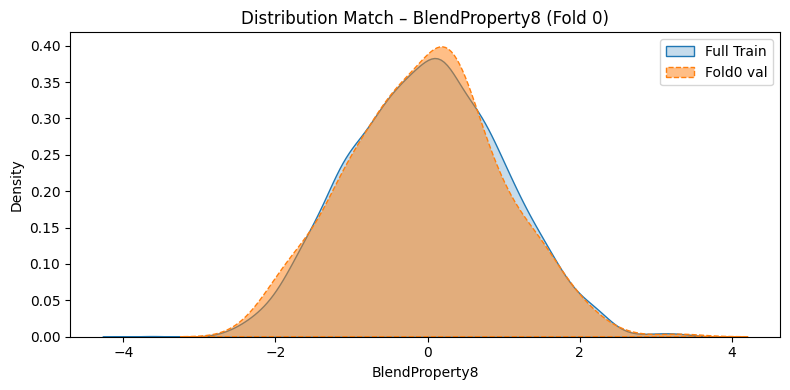

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


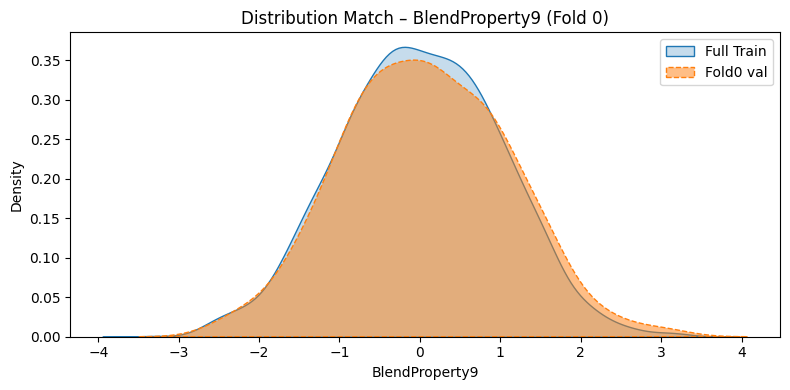

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


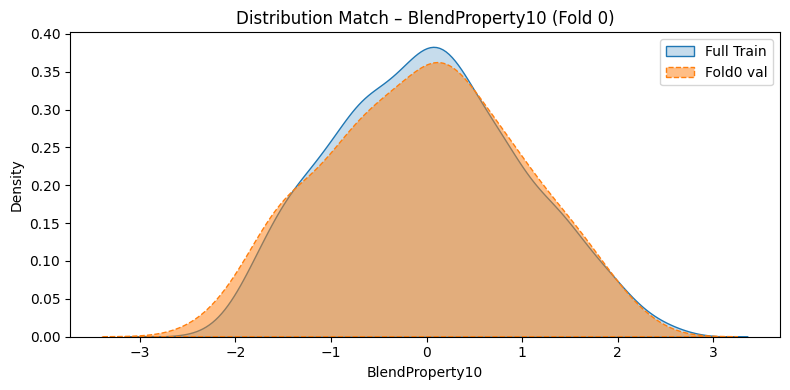

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


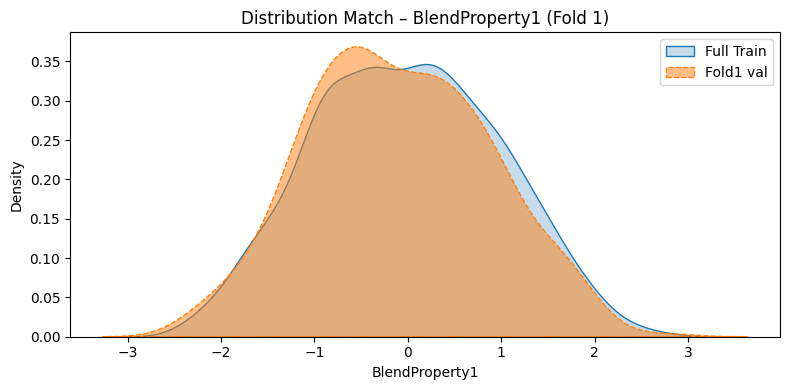

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


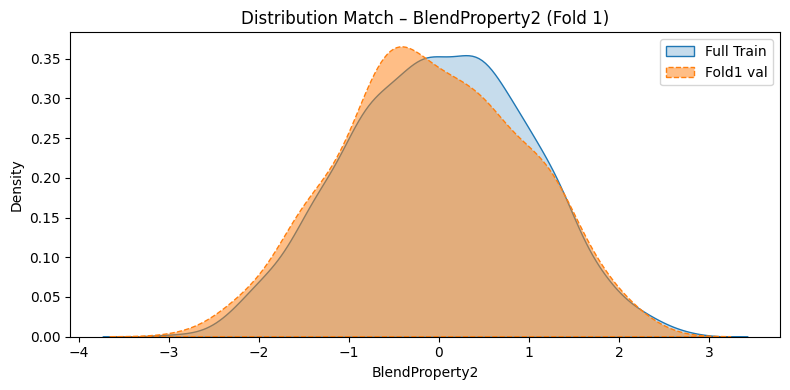

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


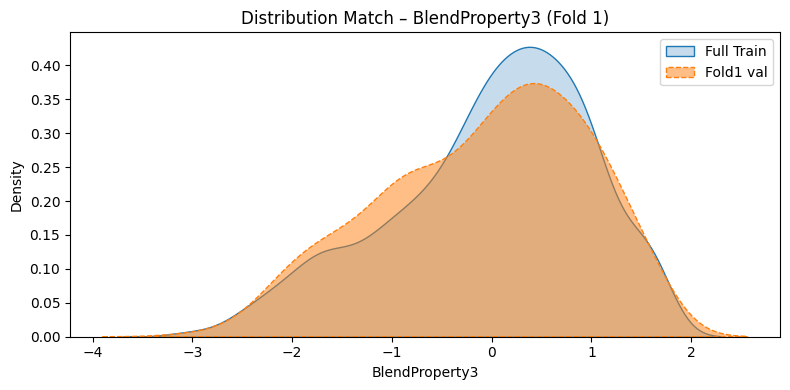

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


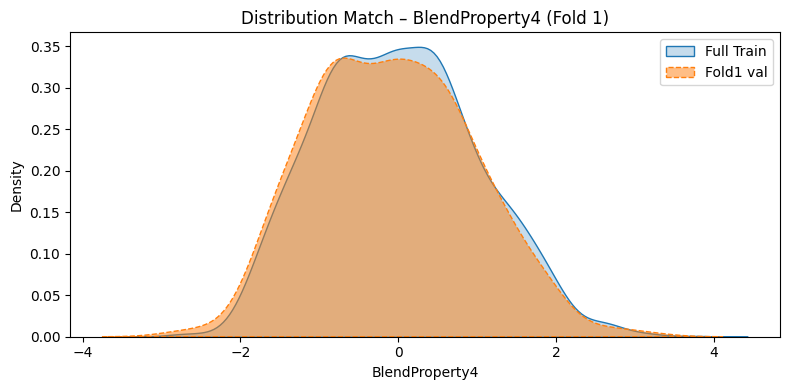

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


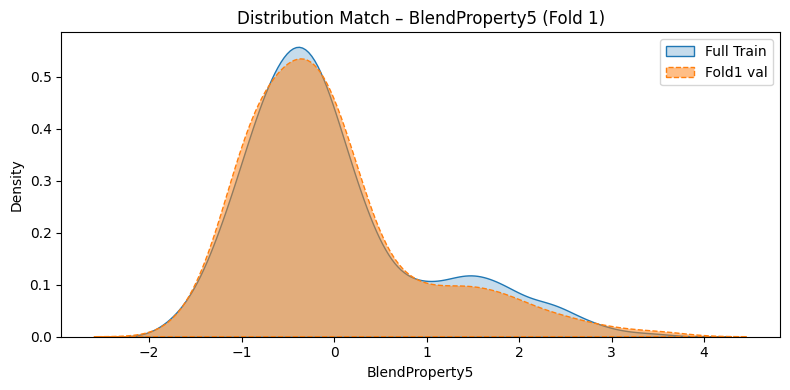

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


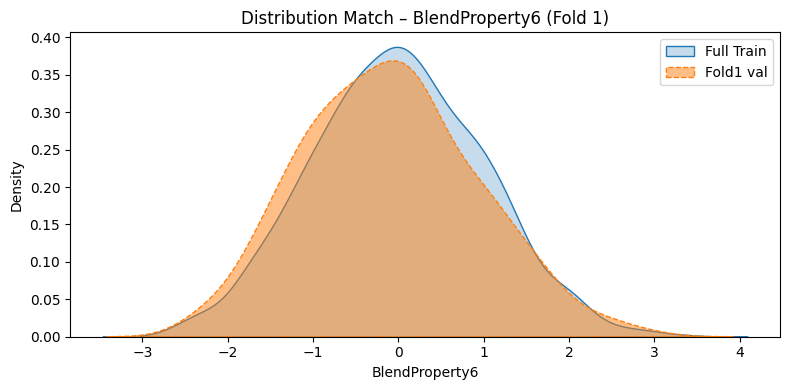

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


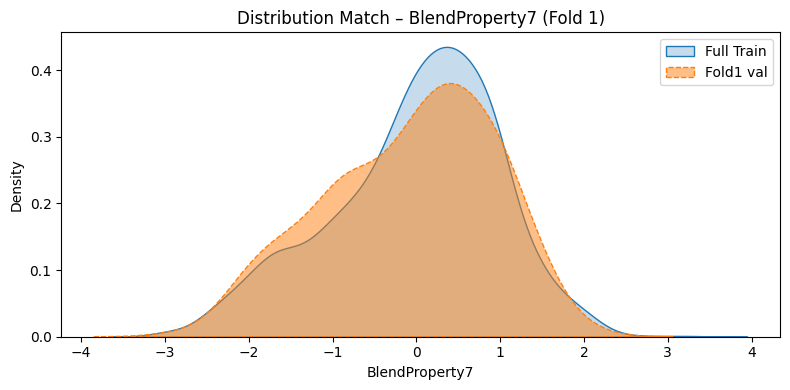

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


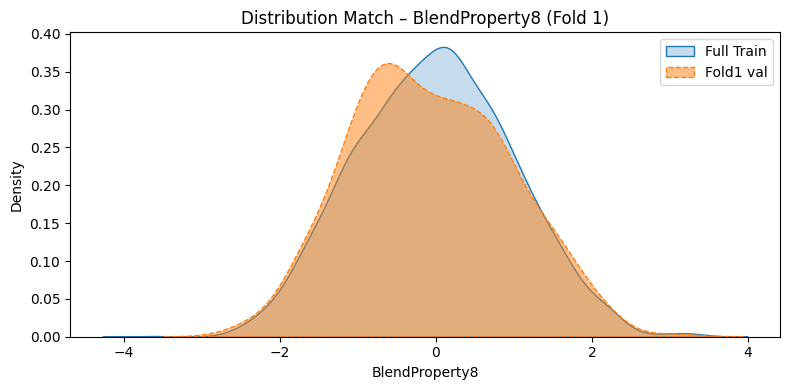

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


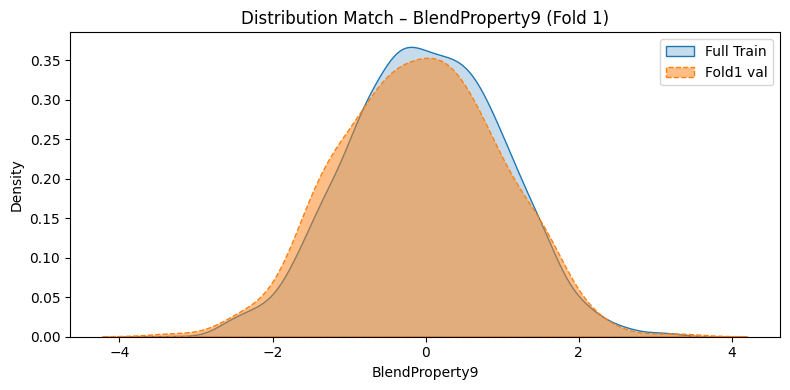

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


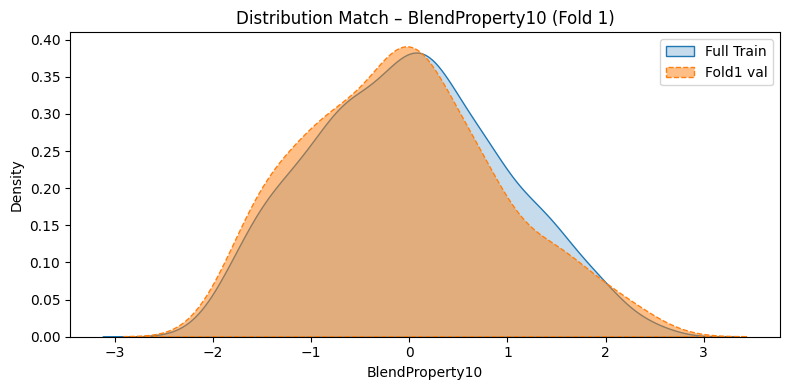

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


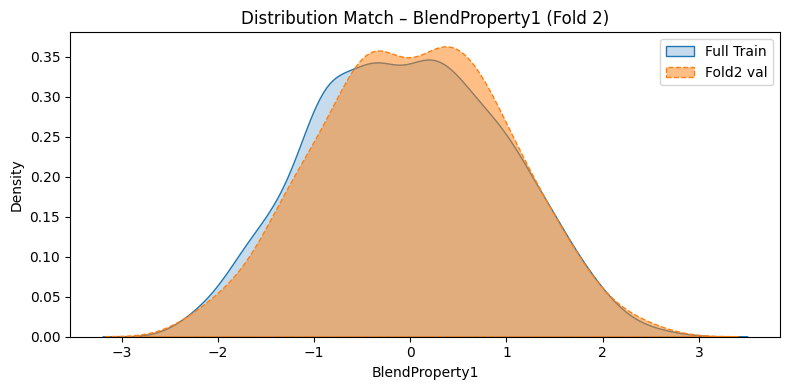

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


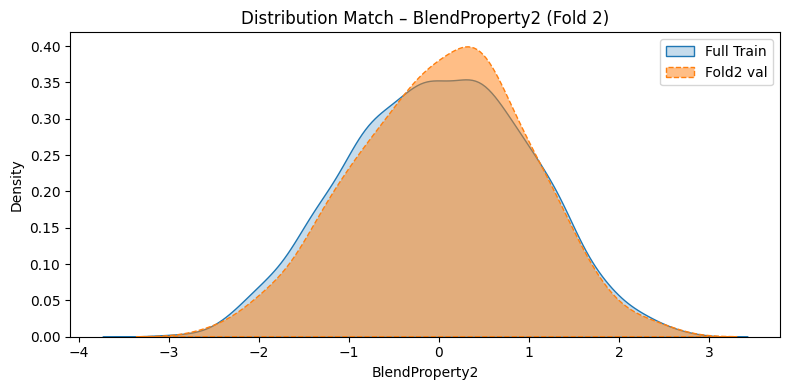

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


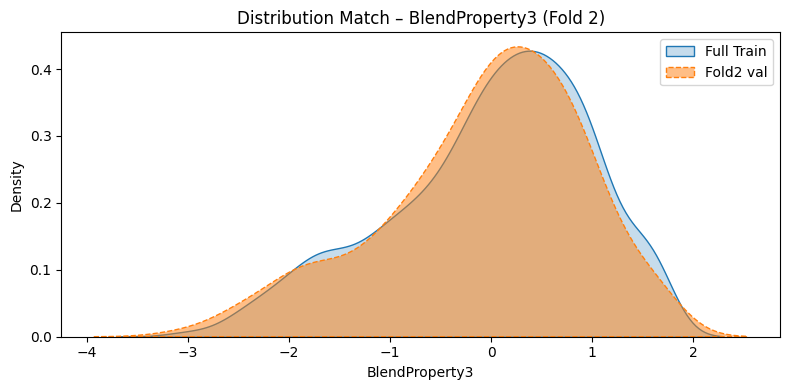

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


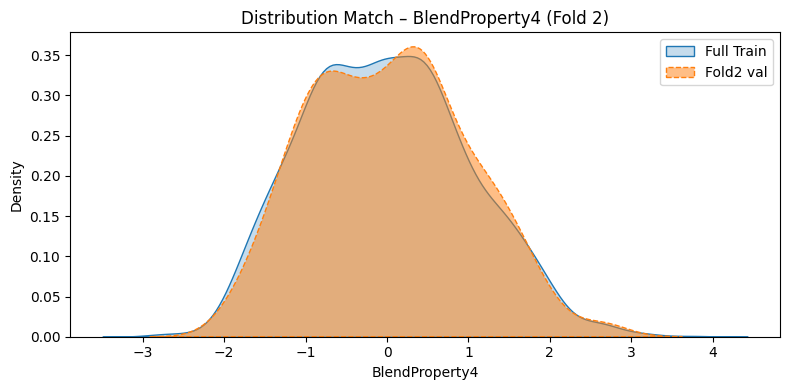

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


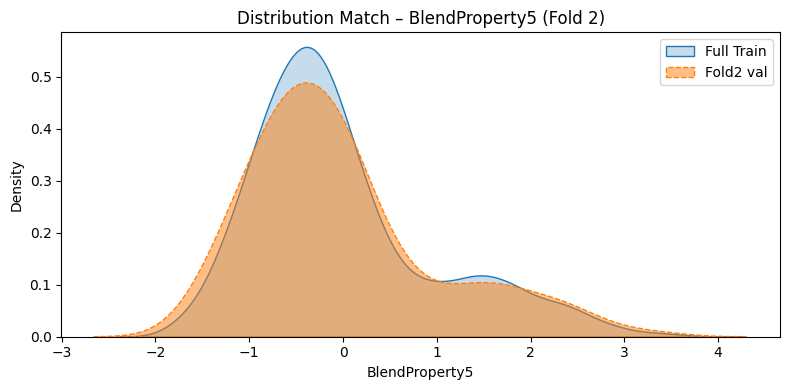

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


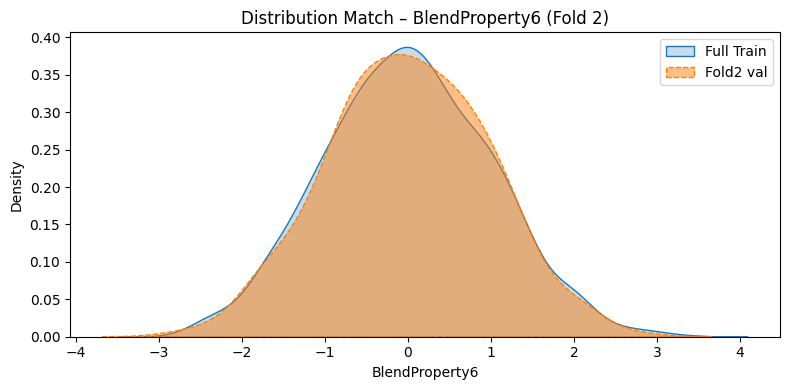

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


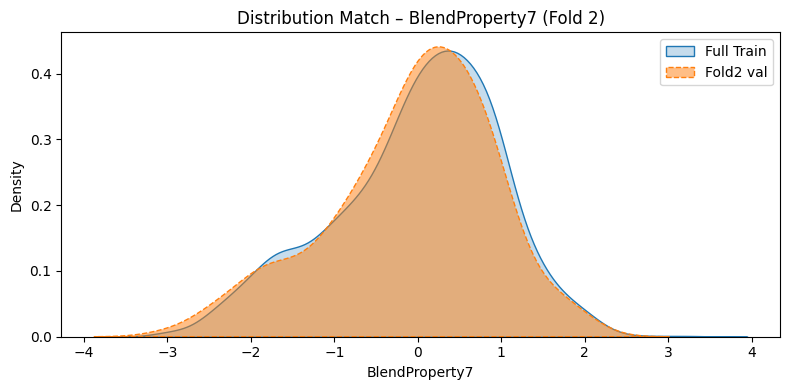

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


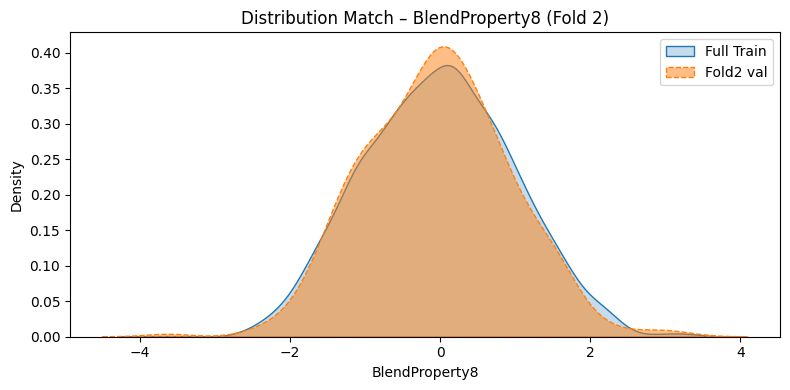

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


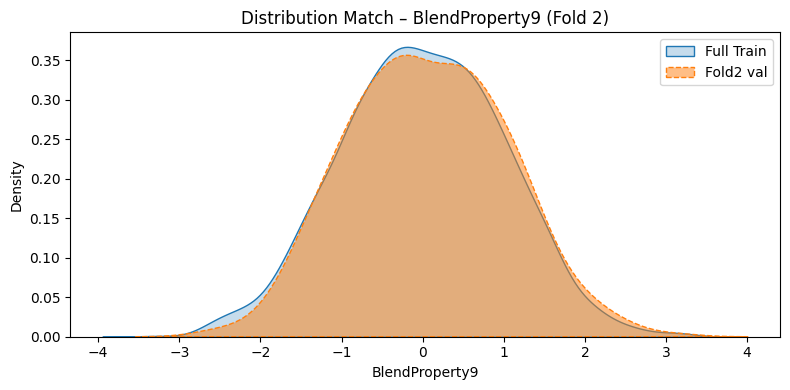

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


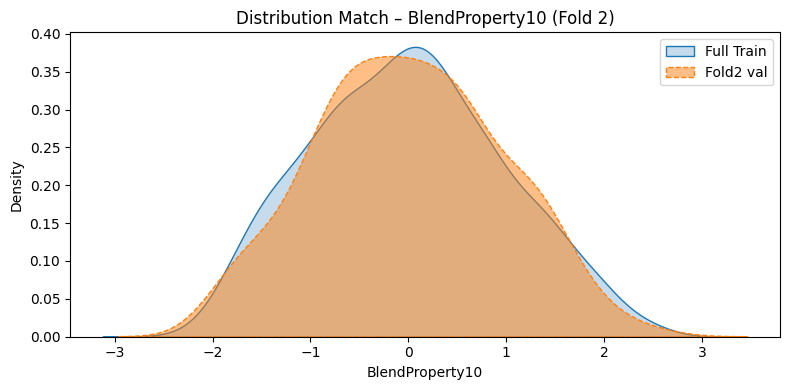

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


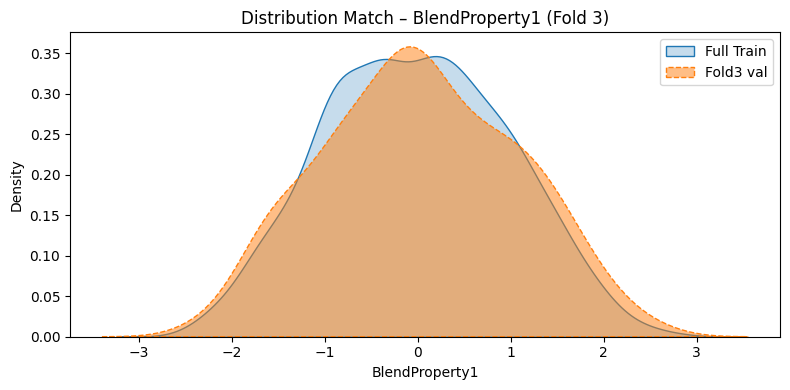

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


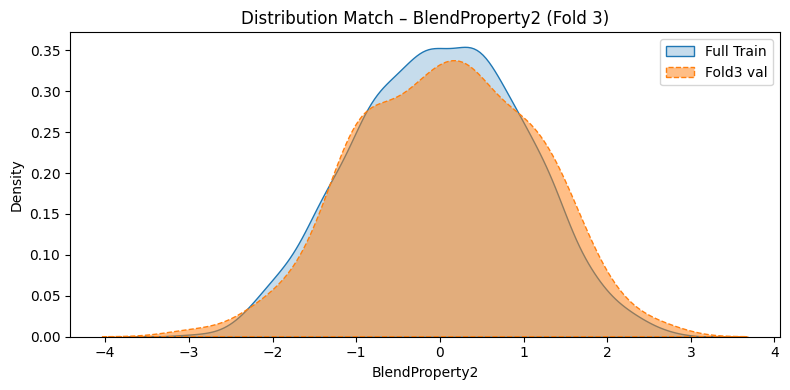

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


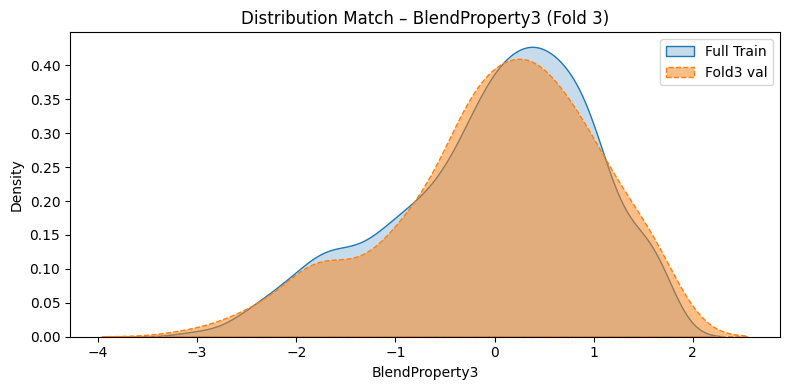

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


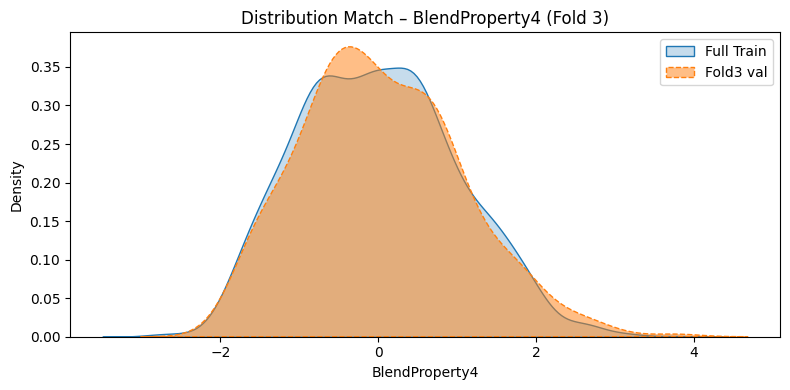

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


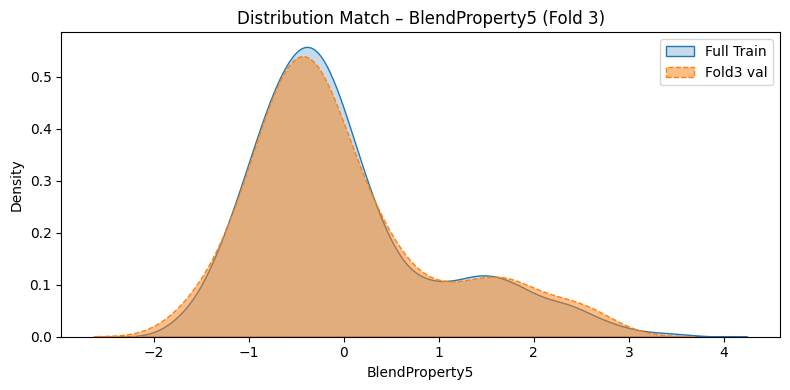

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


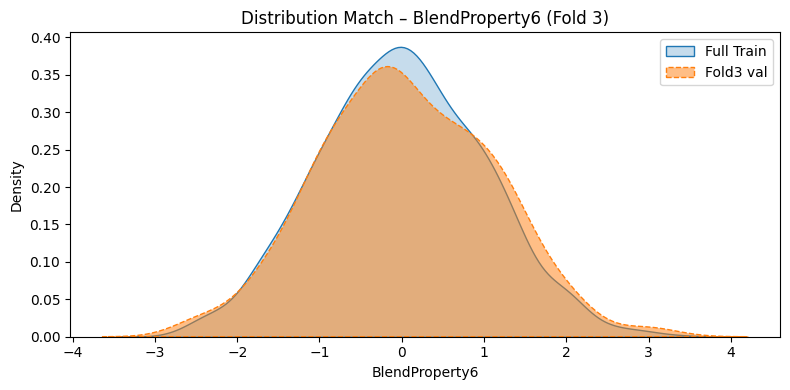

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


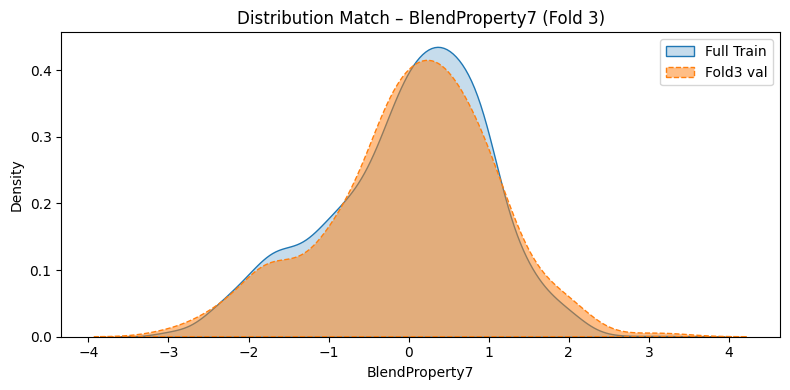

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


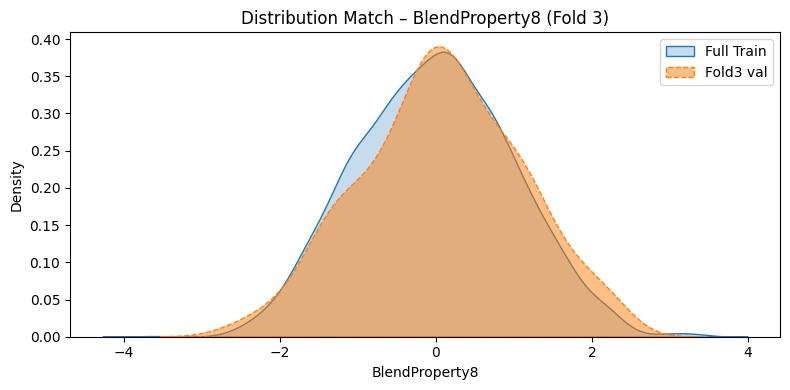

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


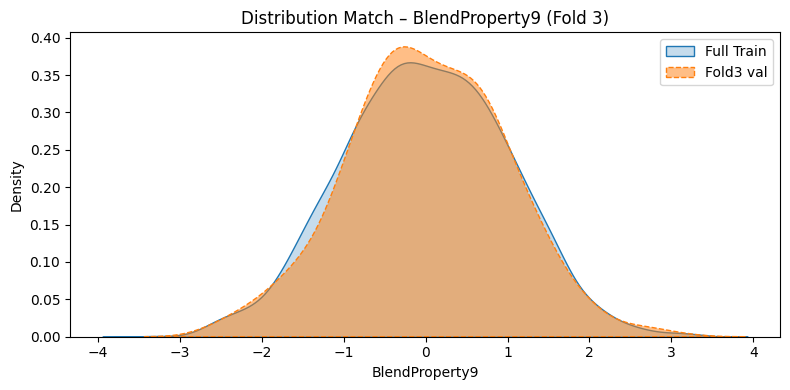

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


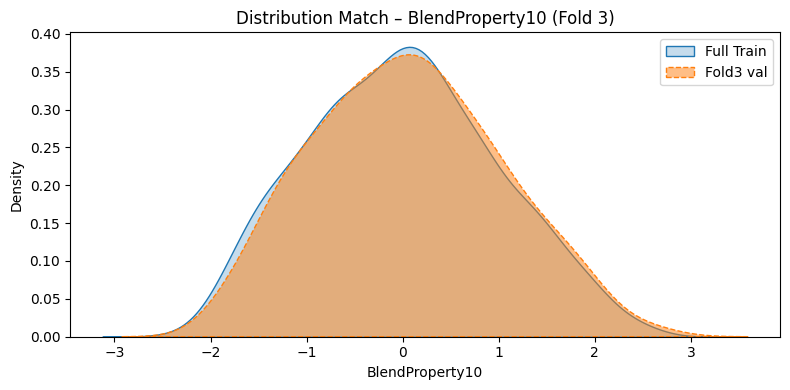

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


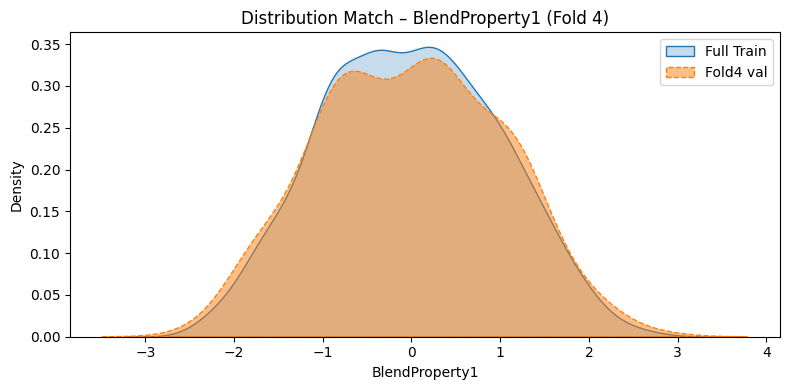

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


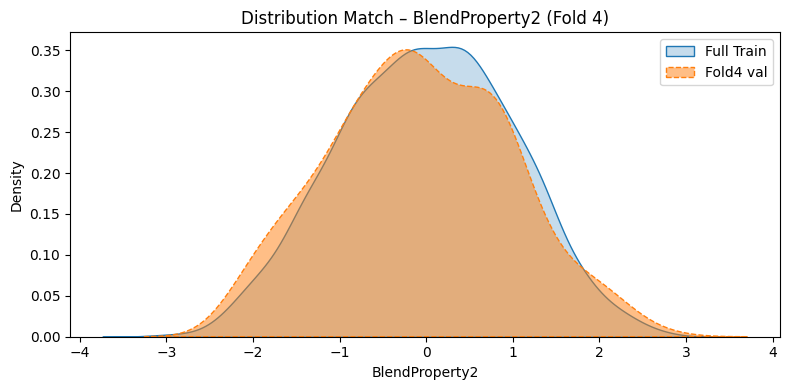

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


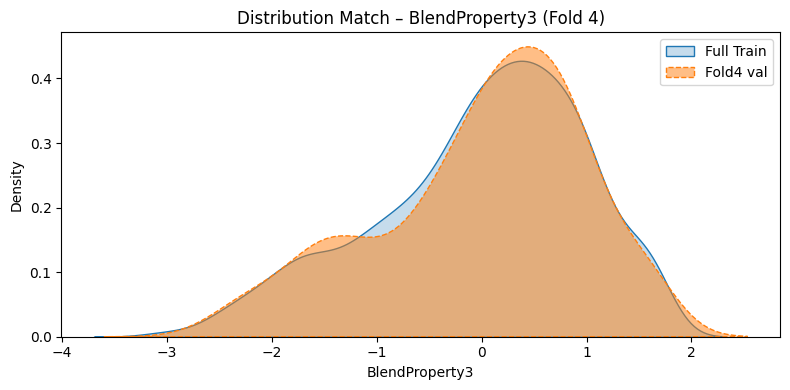

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


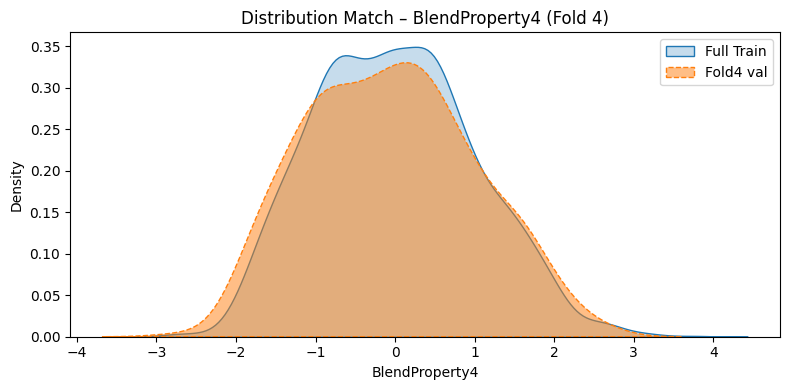

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


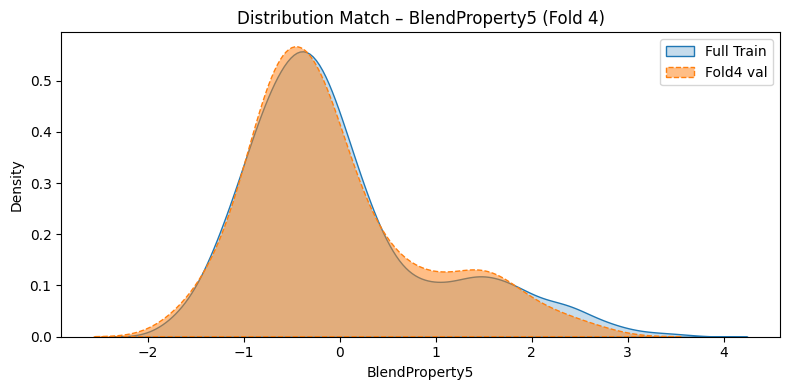

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


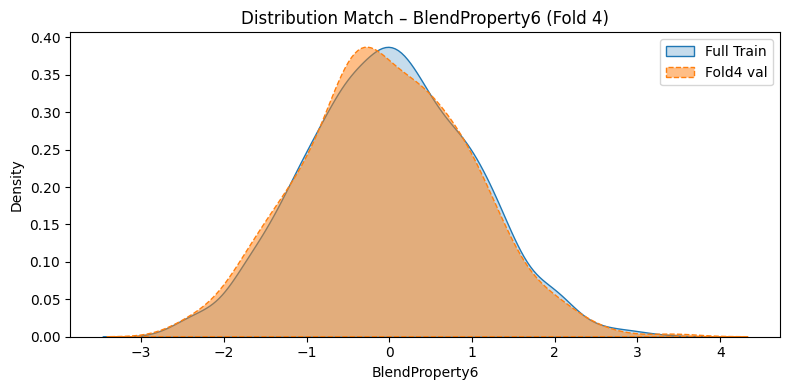

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


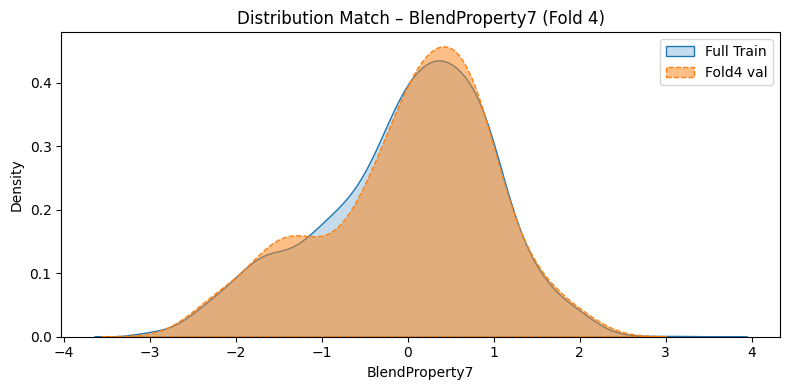

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


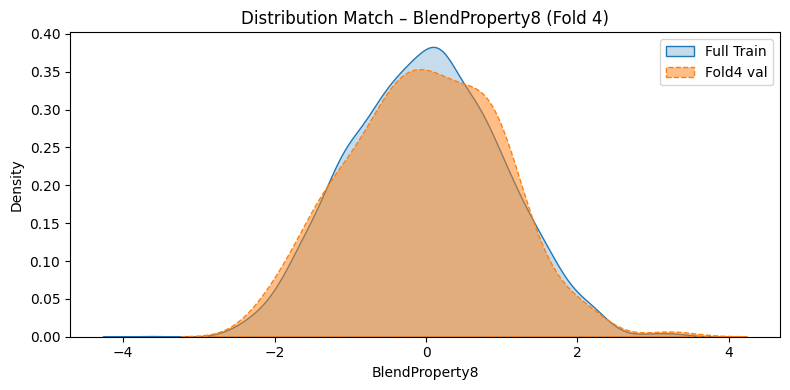

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


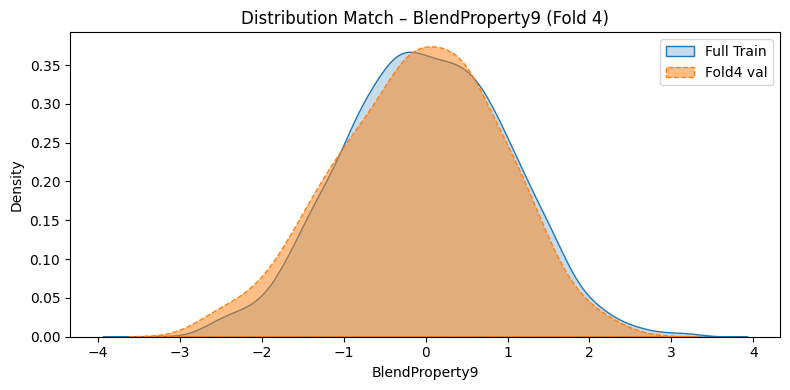

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


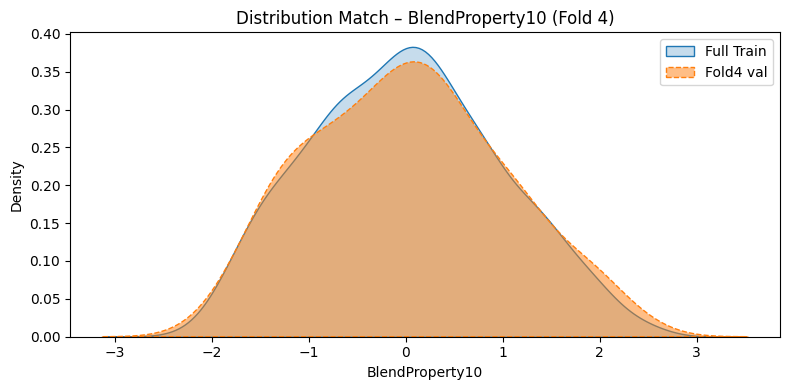

In [9]:
plot_val_distributions(y,base_dir)

In [17]:
def plot_val_distributions(y_full, val_sets):
    import seaborn as sns
    import matplotlib.pyplot as plt
    
    for col in y_full.columns:
        plt.figure(figsize=(8, 4))
        sns.kdeplot(y_full[col], label='Train Full', fill=True)
        sns.kdeplot(val_sets[col]['y_val'][col], label='Val', linestyle='--')
        plt.title(f"Distribution Match – {col}")
        plt.legend()
        plt.show()

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


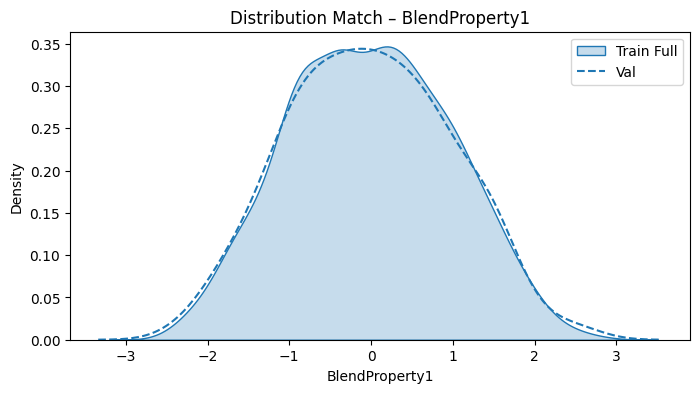

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


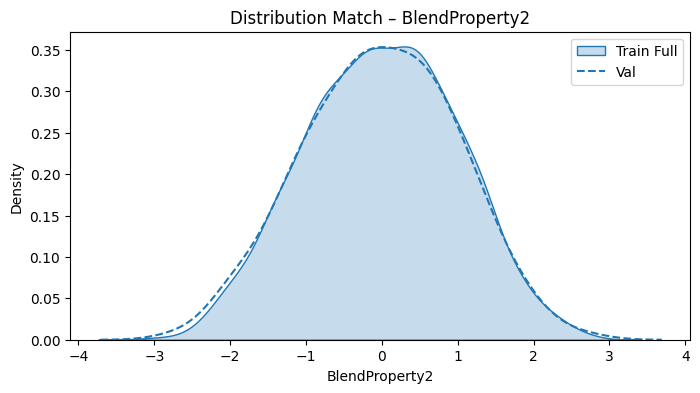

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


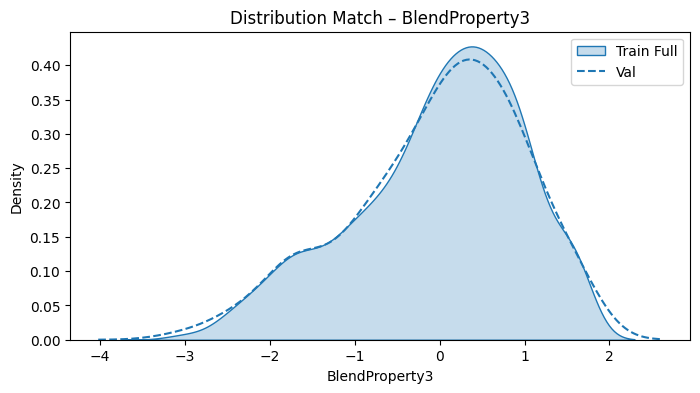

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


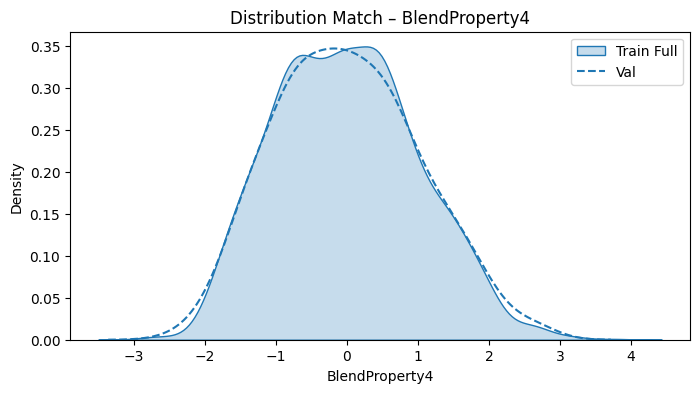

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


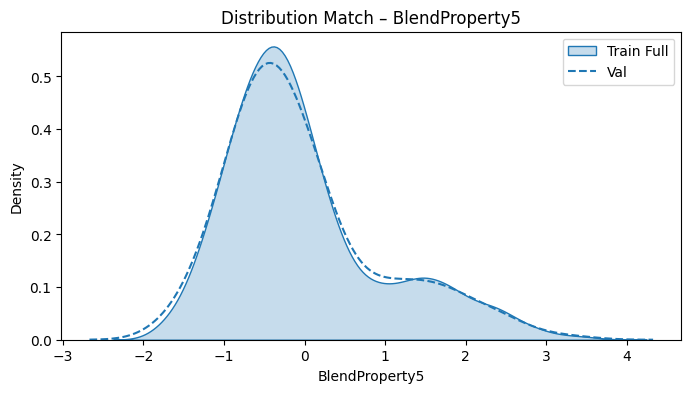

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


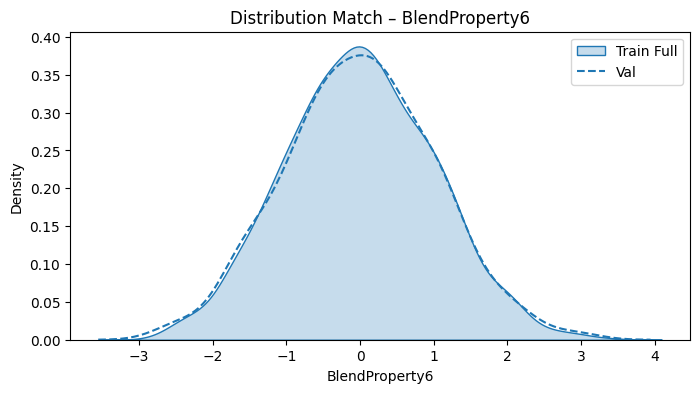

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


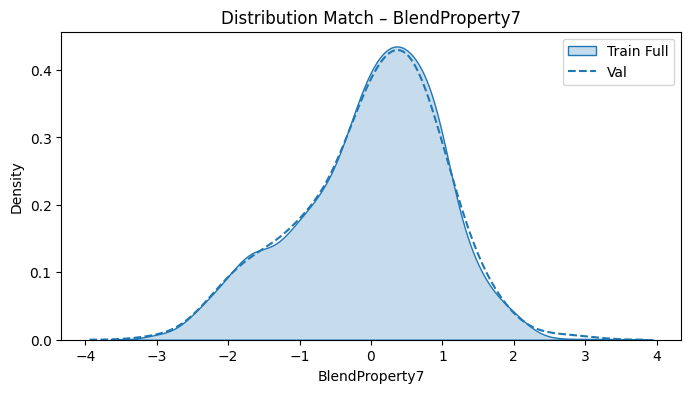

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


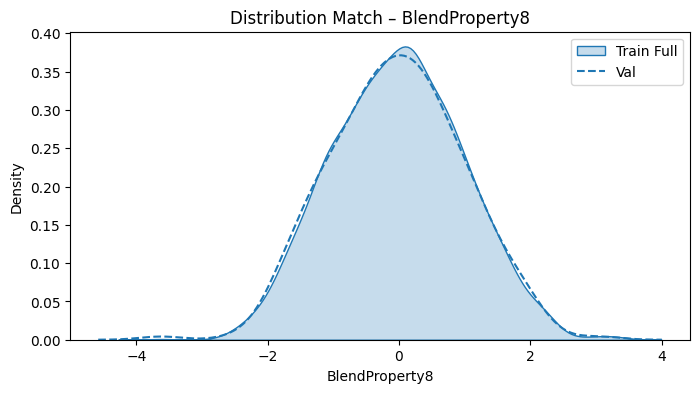

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


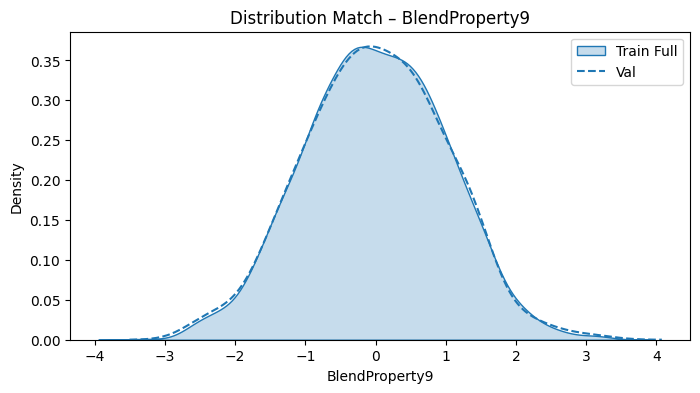

/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/global/homes/r/ritesh11/.local/perlmutter/pytorch2.6.0/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


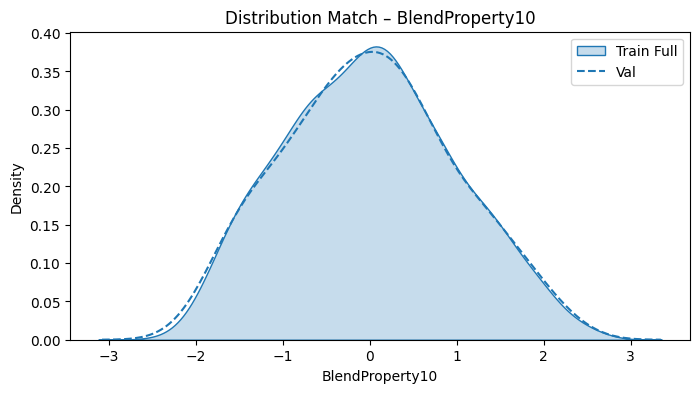

In [18]:
plot_val_distributions(y,val_sets)

In [17]:
val_sets.keys()

dict_keys(['BlendProperty1', 'BlendProperty2', 'BlendProperty3', 'BlendProperty4', 'BlendProperty5', 'BlendProperty6', 'BlendProperty7', 'BlendProperty8', 'BlendProperty9', 'BlendProperty10'])

In [21]:
import os

def save_val_sets(val_sets, train_dir="train", val_dir="val"):
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(val_dir, exist_ok=True)

    for target, splits in val_sets.items():
        suffix = target.replace(" ", "_")  # e.g., BlendProperty1

        # Save training sets
        splits_A = splits
        splits_A['X_train'].to_csv(f"{train_dir}/{suffix}_X.csv", index=False)
        splits_A['y_train'].to_csv(f"{train_dir}/{suffix}_y.csv", index=False, header=[target])

        # Save validation sets
        splits_A['X_val'].to_csv(f"{val_dir}/{suffix}_X.csv", index=False)
        splits_A['y_val'].to_csv(f"{val_dir}/{suffix}_y.csv", index=False, header=[target])

        print(f"Saved: {target}")

# Run the save function
save_val_sets(val_sets)

Saved: BlendProperty1
Saved: BlendProperty2
Saved: BlendProperty3
Saved: BlendProperty4
Saved: BlendProperty5
Saved: BlendProperty6
Saved: BlendProperty7
Saved: BlendProperty8
Saved: BlendProperty9
Saved: BlendProperty10


In [9]:
def val_split_target_only(X, y_col, val_size=300, n_clusters=15, random_state=42):
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(y_col.values.reshape(-1, 1))
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(sss.split(X, clusters))
    
    return train_idx, val_idx

In [10]:
def val_split_pca_xy(X, y_col, val_size=100, n_clusters=10, n_pca=10, random_state=42):
    combined = pd.concat([X, y_col], axis=1)
    
    pca = PCA(n_components=n_pca, random_state=random_state)
    latent = pca.fit_transform(combined)
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=random_state)
    clusters = kmeans.fit_predict(latent)
    
    sss = StratifiedShuffleSplit(n_splits=1, test_size=val_size, random_state=random_state)
    train_idx, val_idx = next(sss.split(combined, clusters))
    
    return train_idx, val_idx

In [11]:
from sklearn.decomposition import PCA

In [12]:
val_sets = {}

for col in y.columns:
    train_A, val_A = val_split_target_only(X, y[col])
    train_B, val_B = val_split_pca_xy(X, y[[col]])  # Keep y as DataFrame

    val_sets[col] = {
        'strategy_A': {
            'X_train': X.iloc[train_A],
            'y_train': y[col].iloc[train_A],
            'X_val': X.iloc[val_A],
            'y_val': y[col].iloc[val_A]
        },
        'strategy_B': {
            'X_train': X.iloc[train_B],
            'y_train': y[col].iloc[train_B],
            'X_val': X.iloc[val_B],
            'y_val': y[col].iloc[val_B]
        }
    }


In [13]:
from scipy.stats import entropy, wasserstein_distance

def kl_divergence(p, q, bins=50):
    p_hist, _ = np.histogram(p, bins=bins, density=True)
    q_hist, _ = np.histogram(q, bins=bins, density=True)
    return entropy(p_hist + 1e-8, q_hist + 1e-8)

def compare_strategies(val_sets):
    results = []

    for col, d in val_sets.items():
        y_train_A = d['strategy_A']['y_train']
        y_val_A = d['strategy_A']['y_val']
        y_train_B = d['strategy_B']['y_train']
        y_val_B = d['strategy_B']['y_val']

        kl_A = kl_divergence(y_train_A, y_val_A)
        kl_B = kl_divergence(y_train_B, y_val_B)
        ws_A = wasserstein_distance(y_train_A, y_val_A)
        ws_B = wasserstein_distance(y_train_B, y_val_B)

        results.append({
            'Target': col,
            'KL_A': kl_A,
            'KL_B': kl_B,
            'Wasserstein_A': ws_A,
            'Wasserstein_B': ws_B,
            'Range_train': (y_train_A.min(), y_train_A.max()),
            'Range_val_A': (y_val_A.min(), y_val_A.max()),
            'Range_val_B': (y_val_B.min(), y_val_B.max())
        })

    return pd.DataFrame(results)

In [14]:
results_df = compare_strategies(val_sets)
results_df['Winner'] = results_df.apply(
    lambda row: 'B' if row['KL_B'] < row['KL_A'] and row['Wasserstein_B'] < row['Wasserstein_A'] else 'A',
    axis=1
)
print(results_df[['Target', 'KL_A', 'KL_B', 'Wasserstein_A', 'Wasserstein_B', 'Winner']])


            Target      KL_A      KL_B  Wasserstein_A  Wasserstein_B Winner
0   BlendProperty1  0.141898  1.911683       0.025122       0.093421      A
1   BlendProperty2  0.202451  1.637197       0.031687       0.076565      A
2   BlendProperty3  0.345574  1.389905       0.026889       0.127319      A
3   BlendProperty4  0.184434  1.092584       0.029788       0.095360      A
4   BlendProperty5  0.116404  1.460174       0.024468       0.160402      A
5   BlendProperty6  0.301028  1.934933       0.030874       0.082333      A
6   BlendProperty7  0.127899  2.192390       0.029750       0.075818      A
7   BlendProperty8  1.502668  0.494300       0.030087       0.093890      A
8   BlendProperty9  0.630911  0.600997       0.025260       0.094442      A
9  BlendProperty10  0.125857  1.610471       0.022975       0.106069      A
